# Analysing Political Executives with AI

## Using AutoGluon to processing the data


```shell
# Link for how to install autogluon on Windows system
# https://auto.gluon.ai/stable/index.html
# For other operation systems, please also check this link for latest news. 

# test automl model
# install autogluon
!pip3 install -U pip
!pip3 install -U setuptools wheel

# CPU version of pytorch has smaller footprint - see installation instructions in
# pytorch documentation - https://pytorch.org/get-started/locally/
!pip3 install torch==1.10.1+cpu -f https://download.pytorch.org/whl/cpu/torch_stable.html

!pip3 install autogluon
!pip3 install shap==0.38.1
```

In [1]:
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import train_test_split #splitting the dataset
import shap
import time
import numpy as np
from ML_figures.figures import act_pred
import pandas as pd

# Showing all the details of results
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# %matplotlib inline

shap.initjs()

import warnings
warnings.filterwarnings('ignore')

/Users/jinxu/miniconda3/envs/ag/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/jinxu/miniconda3/envs/ag/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/jinxu/miniconda3/envs/ag/lib/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit defau

In [2]:
def print_accuracy(f):
    print("Root mean squared test error = {0}".format(np.sqrt(np.mean((f(X_valid) - y_valid)**2))))
    time.sleep(0.5) # to let the print get out before any progress bars

In [3]:
test = pd.read_csv('./../Data/data_AutoGluon_final.csv')

In [4]:
# Import the data file
train_data = pd.read_csv('./../Data/data_AutoGluon_final.csv')

type(train_data)

train_data.columns

train_data.describe()

pandas.core.frame.DataFrame

Index(['ccode', 'leader', 'entry', 'exit', 'exitcode', 'prevtimesinoffice',
       'posttenurefate', 'gender', 'yrborn', 'yrdied', 'numentry', 'numexit',
       'yrbegin', 'yrend', 'pop_x', 'begin_gdppc', 'pop_y', 'age', 'tenure',
       'growth_rate', 'fties_range', 'growth_rate_normgroup',
       'growth_rate_avggrp'],
      dtype='object')

,ccode,entry,exit,exitcode,prevtimesinoffice,posttenurefate,gender,yrborn,yrdied,numentry,...,yrend,pop_x,begin_gdppc,pop_y,age,tenure,growth_rate,fties_range,growth_rate_normgroup,growth_rate_avggrp
count,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,...,1445.000000,1.418000e+03,1445.000000,1.414000e+03,1445.000000,1445.000000,1445.000000,1445.0,1445.000000,1445.000000
mean,321.386851,1.179931,1.718339,6.042215,0.248443,5.043599,0.976471,1904.426990,1129.386851,0.179931,...,1963.420761,3.800084e+04,7674.496680,3.585727e+04,55.302422,3.519277,0.020987,1.0,3.960554,5.245675
std,228.058153,0.408716,1.498005,2.733098,0.593016,1.962645,0.151630,37.453661,1260.779401,0.408716,...,36.850132,1.228420e+05,9883.426834,1.154442e+05,10.365176,4.919002,0.069253,0.0,0.537224,0.578819
min,2.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1808.000000,-999.000000,0.000000,...,1876.000000,1.344080e+02,377.580100,1.244890e+02,17.000000,0.000000,-0.314587,1.0,1.000000,1.000000
25%,135.000000,1.000000,1.000000,5.000000,0.000000,3.000000,1.000000,1877.000000,-777.000000,0.000000,...,1934.000000,3.017000e+03,2235.000000,2.895750e+03,48.000000,0.700904,0.000036,1.0,4.000000,5.000000
50%,305.000000,1.000000,1.000000,5.000000,0.000000,6.000000,1.000000,1910.000000,1941.000000,0.000000,...,1968.000000,8.085862e+03,4116.000000,7.632500e+03,55.000000,1.913797,0.017473,1.0,4.000000,5.000000
75%,434.000000,1.000000,2.000000,5.000000,0.000000,6.000000,1.000000,1935.000000,1979.000000,0.000000,...,1995.000000,3.168320e+04,8549.647600,2.898448e+04,62.000000,4.454575,0.038393,1.0,4.000000,6.000000
max,812.000000,3.000000,7.000000,15.000000,4.000000,9.000000,1.000000,1983.000000,2014.000000,2.000000,...,2016.000000,1.364827e+06,154159.000000,1.344394e+06,88.000000,49.966803,0.794453,1.0,7.000000,7.000000


## Three difference cases

In [5]:
# delete the leader and gender columns
del train_data['leader']
# del train_data['gender']
# del train_data['fties_range']

# delete other irrelevant columns
del train_data['growth_rate_normgroup']
del train_data['growth_rate_avggrp']
# del train_data['growth_rate']

# change label into growth_rate
id, label = 'leader', 'growth_rate'

# change label into growth_rate_normgroup
# id, label = 'leader', 'growth_rate_normgroup'

# change label into growth_rate_avggrp
# id, label = 'leader', 'growth_rate_avggrp'
df_train = train_data
df_train.dtypes

ccode                  int64
entry                float64
exit                 float64
exitcode             float64
prevtimesinoffice      int64
posttenurefate       float64
gender                 int64
yrborn                 int64
yrdied                 int64
numentry               int64
numexit              float64
yrbegin                int64
yrend                  int64
pop_x                float64
begin_gdppc          float64
pop_y                float64
age                    int64
tenure               float64
growth_rate          float64
fties_range          float64
dtype: object

In [6]:
#split train data and test data
df_train, df_test=train_test_split(train_data, test_size=0.33, random_state=1)
# df_train.shape, df_test.shape

In [7]:
df_train

,ccode,entry,exit,exitcode,prevtimesinoffice,posttenurefate,gender,yrborn,yrdied,numentry,numexit,yrbegin,yrend,pop_x,begin_gdppc,pop_y,age,tenure,growth_rate,fties_range
1290,700,1.0,2.0,11.0,0,6.0,1,1939,2012,0,3.0,1992,1996,20111.00000,843.8753,15023.00000,53,4.249232,-0.057757,1.0
274,101,1.0,7.0,15.0,0,8.0,1,1962,-777,0,-888.0,2012,2015,29726.84925,18549.0000,28759.62381,50,3.822118,0.003410,1.0
205,100,1.0,1.0,5.0,0,6.0,1,1854,1928,0,1.0,1909,1910,4890.00000,1197.0000,4793.00000,55,0.947316,0.037594,1.0
913,350,1.0,1.0,5.0,0,6.0,1,1890,1978,0,1.0,1958,1959,8258.16200,4723.0000,8173.12900,68,0.199867,0.026043,1.0
286,130,1.0,2.0,7.0,0,2.0,1,1863,1928,0,3.0,1924,1925,1865.00000,1749.0000,1850.00000,61,0.851489,0.009148,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,305,1.0,1.0,5.0,1,6.0,1,1876,1932,0,1.0,1926,1929,6396.00000,8883.0000,6064.00000,50,2.453165,-0.018537,1.0
905,350,1.0,1.0,5.0,0,6.0,1,1894,1964,0,1.0,1950,1951,7646.40200,3052.0000,7566.02800,56,0.062972,0.076999,1.0
1096,450,1.0,1.0,5.0,0,6.0,1,1943,-777,0,1.0,1995,1996,2130.00000,377.5801,2075.00000,52,1.007550,0.017885,1.0
235,100,1.0,7.0,15.0,0,8.0,1,1951,-777,0,-888.0,2010,2015,46553.15080,11191.6864,43952.32440,59,5.399153,0.030176,1.0


In [8]:
X_train = df_train.drop(columns=[label])
X_valid = df_test.drop(columns=[label])
y_train = df_train[label]
y_valid = df_test[label]
feature_names = X_train.columns

In [9]:
predictor = TabularPredictor(label=label).fit(df_train, presets='high_quality')
# predictor = TabularPredictor(label=label).fit(df_train.drop(columns=[id, 'leader']))

No path specified. Models will be saved in: "AutogluonModels/ag-20230623_042702/"
Presets specified: ['high_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230623_042702/"
AutoGluon Version:  0.8.0
Python Version:     3.9.16
Operating System:   Darwin
Platform Machine:   x86_64
Platform Version:   Darwin Kernel Version 22.5.0: Mon Apr 24 20:51:50 PDT 2023; root:xnu-8796.121.2~5/RELEASE_X86_64
Disk Space Avail:   206.47 GB / 499.96 GB (41.3%)
Train Data Rows:    968
Train Data Columns: 19
Label Column: growth_rate
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (0.602546083459182, -0.3145874751873885, 0.01938, 0.06591)
	If 'regression' is not the correct problem_type, please manually specify the problem

[1000]	valid_set's rmse: 0.0769024
[1000]	valid_set's rmse: 0.0556167


	-0.059	 = Validation score   (-root_mean_squared_error)
	3.35s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-0.0607	 = Validation score   (-root_mean_squared_error)
	2.57s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ...
	-0.0618	 = Validation score   (-root_mean_squared_error)
	0.71s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-0.0565	 = Validation score   (-root_mean_squared_error)
	68.3s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L1 ...
	-0.0599	 = Validation score   (-root_mean_squared_error)
	0.34s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with

[1000]	valid_set's rmse: 0.0650236
[2000]	valid_set's rmse: 0.0642706
[3000]	valid_set's rmse: 0.0641216
[4000]	valid_set's rmse: 0.0641005
[5000]	valid_set's rmse: 0.0640795
[6000]	valid_set's rmse: 0.0640678
[7000]	valid_set's rmse: 0.0640649
[8000]	valid_set's rmse: 0.064063
[9000]	valid_set's rmse: 0.0640619
[10000]	valid_set's rmse: 0.0640612


	-0.0557	 = Validation score   (-root_mean_squared_error)
	8.27s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-0.0579	 = Validation score   (-root_mean_squared_error)
	3.88s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L2 ...
	-0.0549	 = Validation score   (-root_mean_squared_error)
	1.02s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-0.0521	 = Validation score   (-root_mean_squared_error)
	11.8s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L2 ...
	-0.0524	 = Validation score   (-root_mean_squared_error)
	0.48s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L2 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting wi

In [ ]:
x = df_train[label]
y = predictor.predict(df_train.drop(columns=[label]))

# act_pred(x, y, reg_line=True, name = 'ave', save_dir='Images/')

In [ ]:
x = df_test[label]
y = predictor.predict(df_test.drop(columns=[label]))

# act_pred(x, y, reg_line=True, name = 'line', save_dir='Images/')

In [ ]:
# predictor.leaderboard(df_train.drop(columns=[id, 'leader']), silent=True)

In [ ]:
predictor.feature_importance(df_train, subsample_size=None)

In [ ]:
# predictor.evaluate(df_test.drop(columns=[id, 'leader']))

## Explain predictions

SHAP is intended to explain how much each feature contributes to a particular prediction. In this regression context, this corresponds to how much a predicted value differs from a baseline reference value. We first create a wrapper class around AutoGluon to allow it to be called for prediction inside of the `shap` package:

In [10]:
class AutogluonWrapper:
    def __init__(self, predictor, feature_names):
        self.ag_model = predictor
        self.feature_names = feature_names
    
    def predict(self, X):
        if isinstance(X, pd.Series):
            X = X.values.reshape(1,-1)
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names)
        return self.ag_model.predict(X)

Next, we define the baseline reference value of the features (AutoGluon predictions will be interpreted in terms of their difference from the prediction for the baseline feature-values). Rather than use the whole training set to estimate average column-values as our reference, we summarize with a set of weighted kmeans, each weighted by the number of points they represent.

In [11]:
X_train_summary = shap.kmeans(X_train, np.size(feature_names))
print("Baseline feature-values: \n", X_train_summary)

Baseline feature-values: 


We can now create a `KernelExplainer` which will return Kernel SHAP values to explain particular AutoGluon predictions.

In [19]:
ag_wrapper = AutogluonWrapper(predictor, feature_names)
print_accuracy(ag_wrapper.predict)

explainer = shap.KernelExplainer(ag_wrapper.predict, X_train_summary)

NSHAP_SAMPLES = 100  # how many samples to use to approximate each Shapely value, larger values will be slower
N_VAL = 200  # how many datapoints from validation data should we interpret predictions for, larger values will be slower

Root mean squared test error = 0.06790881487450845


In [ ]:
explainer

Let's first explain a prediction for a single datapoint from the training data.

In [20]:
ROW_INDEX = 5  # index of an example datapoint
single_datapoint = X_train.iloc[[ROW_INDEX]]
# print(single_datapoint)
single_prediction = ag_wrapper.predict(single_datapoint)
print(single_prediction)

392    0.019751
Name: growth_rate, dtype: float32


In [21]:
shap_values_single = explainer.shap_values(single_datapoint, nsamples=NSHAP_SAMPLES)
shap.force_plot(explainer.expected_value, shap_values_single, X_train.iloc[ROW_INDEX,:])

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


In [22]:
shap_values = explainer.shap_values(X_valid.iloc[0:N_VAL,:], nsamples=NSHAP_SAMPLES)
# shap.force_plot(explainer.expected_value, shap_values, X_valid.iloc[0:N_VAL,:])

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [04:03<00:00,  1.22s/it]


A summary plot is an even better way to see the relative impact of all features over many datapoints. Features are sorted by the sum of their SHAP value magnitudes across all samples.

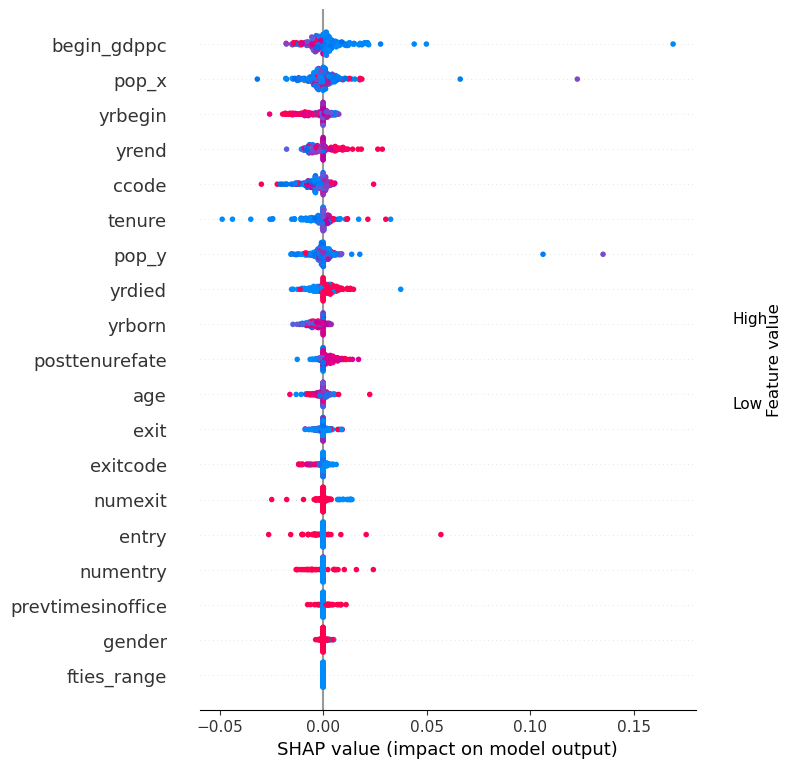

In [25]:
shap.summary_plot(shap_values, X_valid.iloc[0:N_VAL,:])

A dependence plot can be used to visualize how the '' influences predicted outcomes.

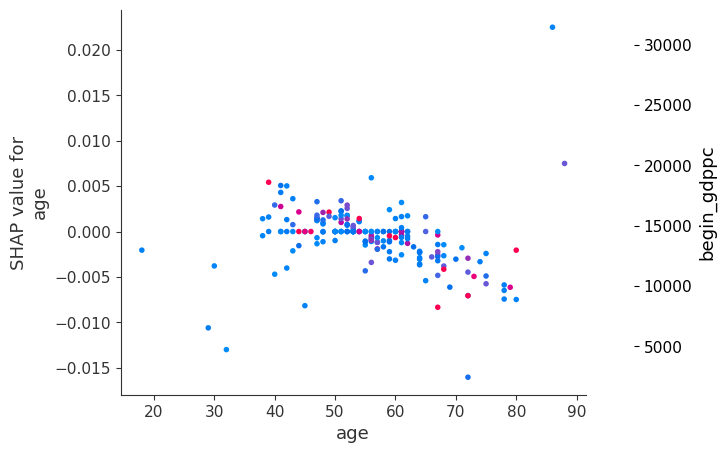

In [24]:
shap.dependence_plot("age", shap_values, X_valid.iloc[0:N_VAL,:])

In [ ]:
shap.plots.scatter(shap_values[:,"age"])